In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:3


In [2]:
def true_SG(xy): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
    term1 = np.exp(xy[:,0]+xy[:,1]-t_val).reshape(-1,1)
    u = 4.0*np.arctan(term1)
    return u

In [3]:
def BC_func(xy):
    x = xy[:,0].reshape(-1,1)
    y = xy[:,1].reshape(-1,1)
    t = torch.tensor(t_val).float().to(device)
    num = 4.0*torch.exp(x+y+t)
    den = torch.exp(2.0*t) + torch.exp(2.0*x + 2.0*y)
    
    return torch.div(num,den)

In [4]:
loss_thresh = 0
level = "_low"
label = "inv_SG_atanh" + level

l_limit = -2.0
u_limit = 2.0

x = np.linspace(l_limit,u_limit,100).reshape(-1,1)
y = np.linspace(l_limit,u_limit,100).reshape(-1,1)

t_val = 2

# t = 3.0*np.ones((1,1))

X,Y = np.meshgrid(x,y)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
  
xy = np.hstack((X,Y))

xy_test_tensor = torch.tensor(xy).float().to(device)

u_true = true_SG(xy)
u_true_norm = np.linalg.norm(u_true,2)

lb_xy = xy[0]
ub_xy = xy[-1]

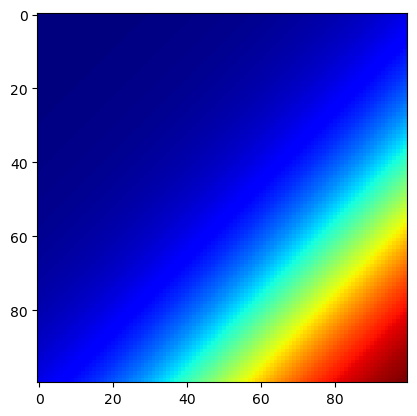

In [5]:
plt.imshow(u_true.reshape(100,100),cmap = 'jet')

In [6]:
def trainingdata(N_T,N_f,N_N,seed):
    np.random.seed(seed)

    #-------------------------------------------------------------------------
    x_NBC_1 = np.vstack((l_limit*np.ones((N_N,1)),u_limit*np.ones((N_N,1))))
    y_NBC_1 = np.random.uniform(l_limit,u_limit,size = (2*N_N,1))

    x_NBC_2 = np.random.uniform(l_limit,u_limit,size = (2*N_N,1))
    y_NBC_2 = np.vstack((l_limit*np.ones((N_N,1)),u_limit*np.ones((N_N,1))))

    xy_NBC1 = np.hstack((x_NBC_1,y_NBC_1))
    xy_NBC2 = np.hstack((x_NBC_2,y_NBC_2))
    
    #----------------------------------------------------------------------------
    xy_d = np.random.uniform(l_limit,u_limit,size = (N_T,2))
    
    xy_D = np.vstack((xy_d,xy_NBC1,xy_NBC2))
    # xy_D = np.vstack((xy_NBC1,xy_NBC2))
    u_D = true_SG(xy_D)
    
    #---------------------------------------------------------------------------
    
    x01 = np.array([[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xy_coll = lb_xy + (ub_xy - lb_xy)*samples
    
    xy_coll = np.vstack((xy_coll, xy_D,xy_NBC1,xy_NBC2)) # append training points to collocation points 
    
    return xy_D,u_D,xy_NBC1,xy_NBC2,xy_coll

In [7]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.alpha = Parameter(torch.ones((50,len(layers)-2)))
        self.alpha.requiresGrad = True
        
        # self.lambdas = torch.tensor([1.0,1.0,1.0,4.0])
        
        self.lambdas = Parameter(torch.tensor([-1.0,-1.0]))
        self.lambdas.requiresGrad = True
        
        self.n = torch.tensor(1.5)
            
    'foward pass'
    def forward(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xy).float().to(device)
        lbxy = torch.from_numpy(lb_xy).float().to(device)
    
                      
        #preprocessing input 
        xyt = 2.0*(xy - lbxy)/(ubxy - lbxy) - 1.0
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a =self.activation(self.n*self.alpha[:,i]*z)
            # a = z1 + self.beta[:,i]*z*z1
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC(self,xy,u):
                
        loss_bc = self.loss_function(self.forward(xy), u)
                
        return loss_bc
    
    def loss_NBC1(self,xy_NBC1,N_hat):
        g = xy_NBC1.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y = autograd.grad(u,g,torch.ones([xy_NBC1.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0] 
            
        du_dx = u_x_y[:,[0]]
        
        f = du_dx - BC_func(g)
        
        loss_NBC1 = self.loss_function(f,N_hat)
        
        return loss_NBC1
    
    def loss_NBC2(self,xy_NBC2,N_hat):
        g = xy_NBC2.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y = autograd.grad(u,g,torch.ones([xy_NBC2.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0] 
            
        du_dy = u_x_y[:,[1]]

        f = du_dy - BC_func(g)
        
        loss_NBC2 = self.loss_function(f,N_hat)
        
        return loss_NBC2
    
    def s_func(self,xy):
        x = xy[:,0].reshape(-1,1)
        y = xy[:,1].reshape(-1,1)
        
        num = torch.exp(3*t_val+x+y) - torch.exp(t_val+3.0*x + 3.0*y)
        den = torch.square(torch.exp(torch.tensor(2.0*t_val).float().to(device)) + torch.exp(2.0*x + 2.0*y))
        
        return torch.div(num,den)
    
    def loss_PDE(self, xy_coll, f_hat):
        
        g = xy_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y = autograd.grad(u,g,torch.ones([xy_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy = autograd.grad(u_x_y,g,torch.ones(xy_coll.shape).to(device), create_graph=True,allow_unused = True)[0]
        
        d2u_dx2 = u_xx_yy[:,[0]]
        d2u_dy2 = u_xx_yy[:,[1]]
        
        #f = self.lambdas[2]*(self.s_func(g.detach())) - self.lambdas[0]*d2u_dx2 - self.lambdas[0]*d2u_dy2 + self.lambdas[2]*torch.sin(u.detach())
        f1 = d2u_dx2 - self.lambdas[0]*d2u_dy2
        f2 = torch.sin(u) - self.lambdas[1]*self.s_func(g)
        
        loss_f = self.loss_function(f1,f_hat) + self.loss_function(f2,f_hat) 
        # print(torch.mean(torch.abs(d2u_dx2)).cpu().detach().numpy())
                
        return loss_f
    
    def loss(self,xy_D,u_D,xy_NBC1,xy_NBC2,xy_coll,f_hat,N_hat):

        loss_BC = self.loss_BC(xy_D,u_D)
        loss_NBC1 = self.loss_NBC1(xy_NBC1,N_hat)
        loss_NBC2 = self.loss_NBC2(xy_NBC2,N_hat)
        loss_f = self.loss_PDE(xy_coll,f_hat)
        
        # loss_val = loss_BC + loss_NBC1 + loss_NBC2 + loss_f
        loss_val = loss_BC + loss_f
        
        return loss_val
         
    'test neural network'
    def test(self):
        u_pred = self.forward(xy_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
        
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
        
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        
        return test_mse, test_re 

In [8]:
def data_update(loss_np):
    train_loss.append(loss_np)

    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [9]:
def train_step(xy_D,u_D,xy_NBC1,xy_NBC2,xy_coll,f_hat,N_hat,seed):

    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(xy_D,u_D,xy_NBC1,xy_NBC2,xy_coll,f_hat,N_hat)
        loss.backward()
        #print(loss.cpu().detach().numpy())
        return loss

    optimizer.step(closure)
      # optimizer.zero_grad()
      # loss = PINN.loss(xy_D,u_D,xy_NBC1,xy_NBC2,xy_coll,f_hat,N_hat)
      # loss.backward()
      # optimizer.step()

In [10]:
def train_model(max_iter,rep): 
    print(rep) 
    torch.manual_seed(rep*9)
    start_time = time.time() 
    thresh_flag = 0

    xy_D,u_D,xy_NBC1,xy_NBC2,xy_coll = trainingdata(N_T,N_f,N_N,rep*22)
        
    xy_coll = torch.from_numpy(xy_coll).float().to(device)
    xy_NBC1 = torch.from_numpy(xy_NBC1).float().to(device)
    xy_NBC2 = torch.from_numpy(xy_NBC2).float().to(device)
    xy_D = torch.from_numpy(xy_D).float().to(device)
    u_D = torch.from_numpy(u_D).float().to(device)
        
    f_hat = torch.zeros(xy_coll.shape[0],1).to(device)
    N_hat = torch.zeros(xy_NBC1.shape[0],1).to(device)


    for i in range(max_iter):
        train_step(xy_D,u_D,xy_NBC1,xy_NBC2,xy_coll,f_hat,N_hat,i)
        loss_np = PINN.loss(xy_D,u_D,xy_NBC1,xy_NBC2,xy_coll,f_hat,N_hat).cpu().detach().numpy()
        
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1          
                thresh_flag = 1       
        data_update(loss_np)
        
        print(i,"Train Loss",train_loss[-1],"RE Loss",test_re_loss[-1],"Lamdas:",np.transpose(PINN.lambdas.cpu().detach().numpy()))
        #print(i,"Train Loss",train_loss[-1],"RE Loss",test_re_loss[-1])
      
    elapsed_time[rep] = time.time() - start_time  
    print('Training time: %.2f' % (elapsed_time[rep]))

In [11]:
max_reps = 1
max_iter = 100 #200

train_loss_full = []
test_mse_full = []
test_re_full = []

elapsed_time= np.zeros((max_reps,1))
time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))


N_T = 10 #Total number of data points for 'y'
N_N = 1000
N_f = 50000 #Total number of collocation points 


for reps in range(max_reps):
    print(label)
    print(reps)
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
 
    
    torch.manual_seed(reps*36)
    
    layers = np.array([2,50,50,50,1]) #9 hidden layers

    PINN = Sequentialmodel(layers)
   
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.25, 
                              max_iter = 20, 
                              max_eval = 30, 
                              tolerance_grad = 1e-08, 
                              tolerance_change = 1e-08, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

    # optimizer = torch.optim.Adam(PINN.parameters(),lr = 0.008)
    
    nan_flag = train_model(max_iter,reps)
    
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    #elapsed_time[reps] = time.time() - start_time

    print('Training time: %.2f' % (elapsed_time[reps]))
    
mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full,"test_re_loss": test_re_full,"Time": elapsed_time, "label": label,"Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic)

inv_SG_atanh_low
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 0.6488259 RE Loss 0.7075855112016161 Lamdas: [-0.8576614 -0.849463 ]
1 Train Loss 0.3880669 RE Loss 0.47659754477385724 Lamdas: [-0.05064221  1.2911296 ]
2 Train Loss 0.1238198 RE Loss 0.16810569533767486 Lamdas: [0.51283544 3.2297854 ]
3 Train Loss 0.026138946 RE Loss 0.056312974245017404 Lamdas: [0.85101676 4.2028637 ]
4 Train Loss 0.0038277947 RE Loss 0.019448579980041947 Lamdas: [0.9914389 4.1721535]
5 Train Loss 0.00076626445 RE Loss 0.007984858350469347 Lamdas: [1.0044899 3.965353 ]
6 Train Loss 0.000265095 RE Loss 0.004050204645230652 Lamdas: [0.9962461 3.9892087]
7 Train Loss 0.00010116294 RE Loss 0.0024004795679

In [12]:
u_pred = PINN.test()

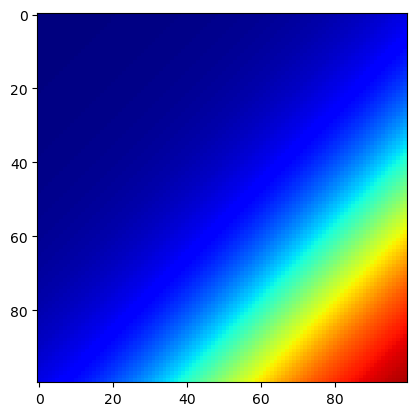

In [13]:
plt.imshow(u_pred.reshape(100,100),cmap = 'jet',vmax = 6, vmin = 0)

In [14]:
np.min(u_pred)

0.009362936